In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import h5py 
import cupy as cp
PLANCK_CONSTANT = 4.135667696e-18  # [keV*s]
SPEED_OF_LIGHT = 299792458  # [m/s]

%matplotlib inline

cp.cuda.Device(1).use()

<CUDA Device 1>

Text(0.5, 1.0, 'dark field')

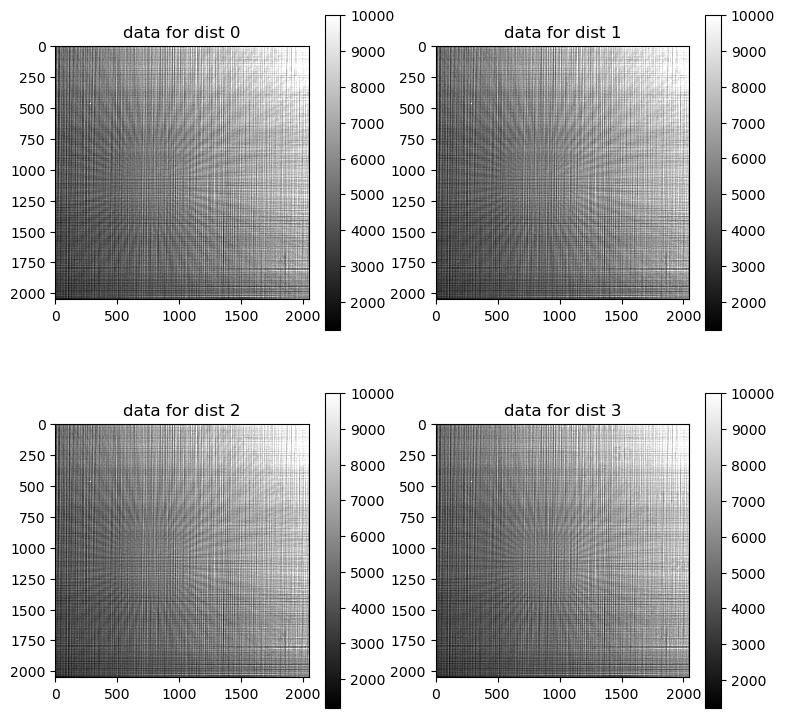

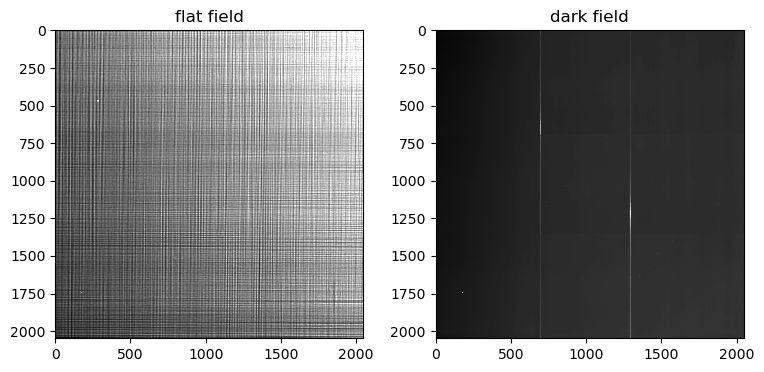

In [13]:
n = 2048
ndist = 4
ntheta = 1

# nref = 20
# ndark = 20
# data0 = np.zeros([ndist,ntheta,n,n],dtype='float32')
# ref0 = np.zeros([nref,ndist,n,n],dtype='float32')
# dark0 = np.zeros([ndark,ndist,n,n],dtype='float32')
# for k in range(ndist):
#     with h5py.File(f'/data/viktor/SiemensLH_33keV_010nm_holoNfpScan_0{k+1}/SiemensLH_33keV_010nm_holoNfpScan_0{k+1}0000.h5','r') as fid:
#         data0[k] = fid['/entry_0000/measurement/data'][:1,1024-n//2:1024+n//2,1024-n//2:1024+n//2].copy().astype('float32')
#     with h5py.File(f'/data/viktor/SiemensLH_33keV_010nm_holoNfpScan_0{k+1}/ref_0000.h5','r') as fid:
#         ref0[:,k]=fid['/entry_0000/measurement/data'][:nref,1024-n//2:1024+n//2,1024-n//2:1024+n//2].copy().astype('float32')
#     with h5py.File(f'/data/viktor/SiemensLH_33keV_010nm_holoNfpScan_0{k+1}/dark_0000.h5','r') as fid:
#         dark0[:,k]=fid['/entry_0000/measurement/data'][:ndark,1024-n//2:1024+n//2,1024-n//2:1024+n//2].copy().astype('float32')    

# np.save('data/data.npy',data0)
# np.save('data/ref.npy',np.mean(ref0,axis=0)[np.newaxis])
# np.save('data/dark.npy',np.mean(dark0,axis=0)[np.newaxis])

data0 = np.load('data/data.npy')
ref0 = np.load('data/ref.npy')
dark0 = np.load('data/dark.npy')

fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data0[0,0],cmap='gray',vmax=10000)
axs[0,0].set_title(f'data for dist {0}')
fig.colorbar(im)
im=axs[0,1].imshow(data0[1,0],cmap='gray',vmax=10000)
axs[0,1].set_title(f'data for dist {1}')
fig.colorbar(im)
im=axs[1,0].imshow(data0[2,0],cmap='gray',vmax=10000)
axs[1,0].set_title(f'data for dist {2}')
fig.colorbar(im)
im=axs[1,1].imshow(data0[3,0],cmap='gray',vmax=10000)
axs[1,1].set_title(f'data for dist {3}')
fig.colorbar(im)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(ref0[0,0],cmap='gray',vmax=10000)
axs[0].set_title(f'flat field')
im=axs[1].imshow(dark0[0,0],cmap='gray',vmax=3000)
axs[1].set_title(f'dark field')  

# Dark-flat field correction

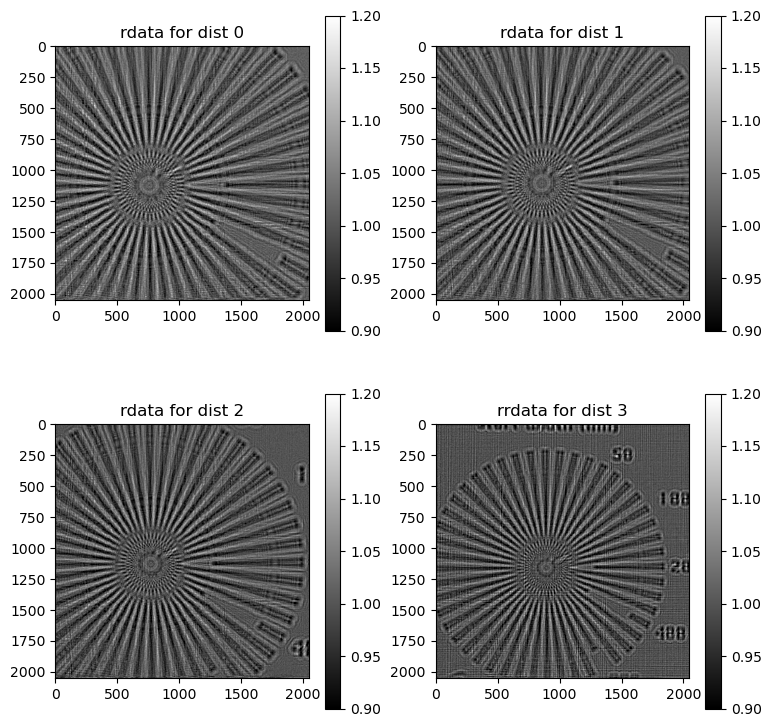

In [14]:
rdata = (data0-np.mean(dark0,axis=0))
rref = (np.mean(ref0,axis=0)-np.mean(dark0,axis=0))
rref[rref<0] = 0
rdata[rdata<0]=0
rdata/=(rref+1e-9)

fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(rdata[0,0],cmap='gray',vmin = 0.9,vmax=1.2 )
axs[0,0].set_title(f'rdata for dist {0}')
fig.colorbar(im)
im=axs[0,1].imshow(rdata[1,0],cmap='gray',vmin = 0.9,vmax=1.2 )
axs[0,1].set_title(f'rdata for dist {1}')
fig.colorbar(im)
im=axs[1,0].imshow(rdata[2,0],cmap='gray',vmin = 0.9,vmax=1.2 )
axs[1,0].set_title(f'rdata for dist {2}')
fig.colorbar(im)
im=axs[1,1].imshow(rdata[3,0],cmap='gray',vmin = 0.9,vmax=1.2 )
axs[1,1].set_title(f'rrdata for dist {3}')
fig.colorbar(im)
    

# Init data sizes and parametes of the PXM of ID16A

In [15]:
voxelsize = 10e-9 # [m] object voxel size 
energy = 33.35  # [keV] x-ray energy    
wavelength = PLANCK_CONSTANT * SPEED_OF_LIGHT / energy # [m]
focusToDetectorDistance = 1.28 # [m]


sx0 = 3.7e-4# [m] motor offset from the focal spot
z1 = np.array([4.584e-3,4.765e-3,5.488e-3,6.9895e-3])-sx0 # positions of the sample (1 position is enough when using several codes)
z1=z1[:ndist]
z2 = focusToDetectorDistance-z1 # propagation distance between the code and detector
magnifications = (z1+z2)/z1 # magnification when propagating from the sample to the code
norm_magnifications = magnifications/magnifications[0] # normalized magnifications
distances = (z1*z2)/(z1+z2) # propagation distances after switching from the point source wave to plane wave,
distances = distances*norm_magnifications**2 # scaled propagation distances due to magnified probes
voxelsize/norm_magnifications

array([1.00000000e-08, 1.04295206e-08, 1.21452302e-08, 1.57083531e-08])

# Scale everything to 1 magnification

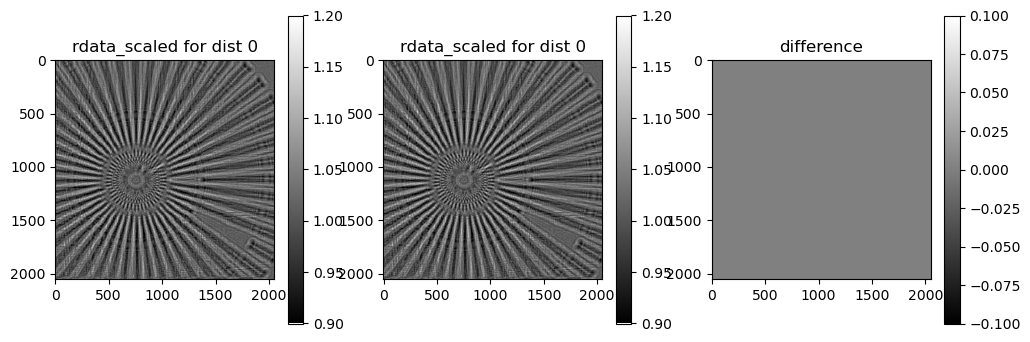

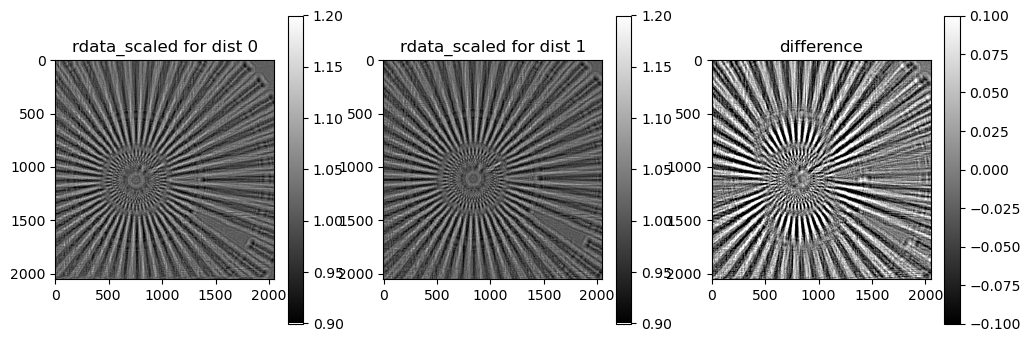

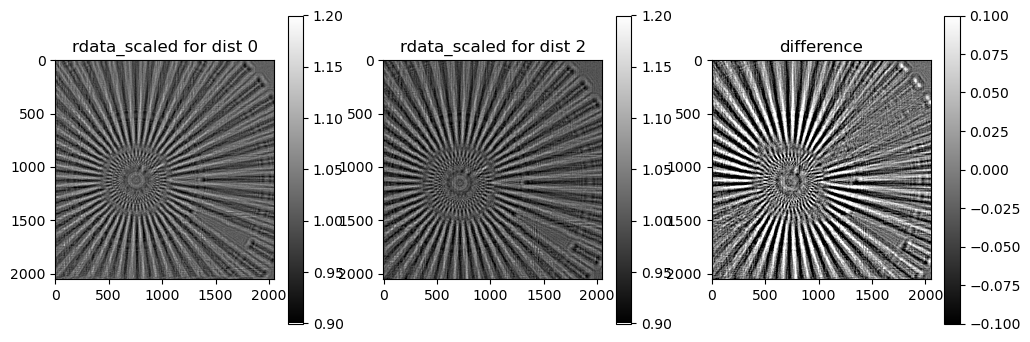

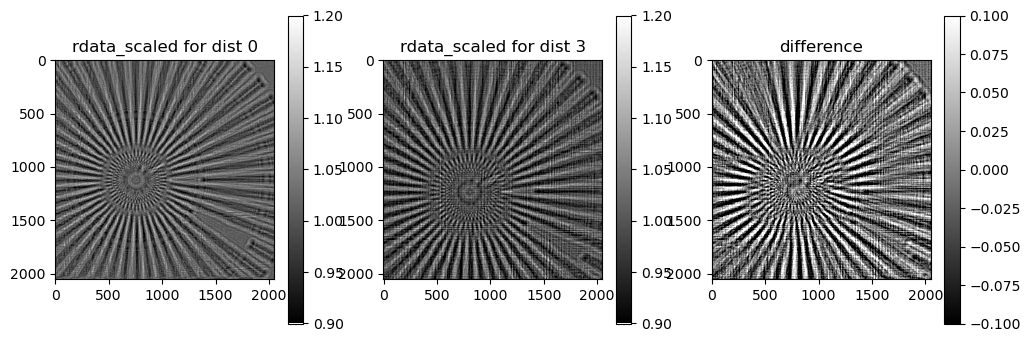

In [16]:
rdata_scaled = rdata.copy()
for k in range(ndist):    
    a = ndimage.zoom(rdata[k,0],1/norm_magnifications[k])
    rdata_scaled[k] = a[a.shape[0]//2-n//2:a.shape[0]//2+n//2,a.shape[1]//2-n//2:a.shape[1]//2+n//2]

for k in range(ndist):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    im=axs[0].imshow(rdata_scaled[0,0],cmap='gray',vmin = 0.9,vmax=1.2 )
    axs[0].set_title(f'rdata_scaled for dist {0}')
    fig.colorbar(im)
    im=axs[1].imshow(rdata_scaled[k,0],cmap='gray',vmin = 0.9,vmax=1.2 )
    axs[1].set_title(f'rdata_scaled for dist {k}')
    fig.colorbar(im)        
    im=axs[2].imshow(rdata_scaled[k,0]-rdata_scaled[0,0],cmap='gray',vmin =-0.1,vmax=0.1 )
    axs[2].set_title(f'difference')
    fig.colorbar(im)        

# Align data between different magnifications

In [17]:
def _upsampled_dft(data, ups,
                   upsample_factor=1, axis_offsets=None):

    im2pi = 1j * 2 * np.pi
    tdata = data.copy()
    kernel = (np.tile(np.arange(ups), (data.shape[0], 1))-axis_offsets[:, 1:2])[
        :, :, None]*np.fft.fftfreq(data.shape[2], upsample_factor)
    kernel = np.exp(-im2pi * kernel)
    tdata = np.einsum('ijk,ipk->ijp', kernel, tdata)
    kernel = (np.tile(np.arange(ups), (data.shape[0], 1))-axis_offsets[:, 0:1])[
        :, :, None]*np.fft.fftfreq(data.shape[1], upsample_factor)
    kernel = np.exp(-im2pi * kernel)
    rec = np.einsum('ijk,ipk->ijp', kernel, tdata)

    return rec

def registration_shift(src_image, target_image, upsample_factor=1, space="real"):

    # assume complex data is already in Fourier space
    if space.lower() == 'fourier':
        src_freq = src_image
        target_freq = target_image
    # real data needs to be fft'd.
    elif space.lower() == 'real':
        src_freq = np.fft.fft2(src_image)
        target_freq = np.fft.fft2(target_image)

    # Whole-pixel shift - Compute cross-correlation by an IFFT
    shape = src_freq.shape
    image_product = src_freq * target_freq.conj()
    cross_correlation = np.fft.ifft2(image_product)
    A = np.abs(cross_correlation)
    maxima = A.reshape(A.shape[0], -1).argmax(1)
    maxima = np.column_stack(np.unravel_index(maxima, A[0, :, :].shape))

    midpoints = np.array([np.fix(axis_size / 2)
                          for axis_size in shape[1:]])

    shifts = np.array(maxima, dtype=np.float64)
    ids = np.where(shifts[:, 0] > midpoints[0])
    shifts[ids[0], 0] -= shape[1]
    ids = np.where(shifts[:, 1] > midpoints[1])
    shifts[ids[0], 1] -= shape[2]
    
    if upsample_factor > 1:
        # Initial shift estimate in upsampled grid
        shifts = np.round(shifts * upsample_factor) / upsample_factor
        upsampled_region_size = np.ceil(upsample_factor * 1.5)
        # Center of output array at dftshift + 1
        dftshift = np.fix(upsampled_region_size / 2.0)

        normalization = (src_freq[0].size * upsample_factor ** 2)
        # Matrix multiply DFT around the current shift estimate

        sample_region_offset = dftshift - shifts*upsample_factor
        cross_correlation = _upsampled_dft(image_product.conj(),
                                                upsampled_region_size,
                                                upsample_factor,
                                                sample_region_offset).conj()
        cross_correlation /= normalization
        # Locate maximum and map back to original pixel grid
        A = np.abs(cross_correlation)
        maxima = A.reshape(A.shape[0], -1).argmax(1)
        maxima = np.column_stack(
            np.unravel_index(maxima, A[0, :, :].shape))

        maxima = np.array(maxima, dtype=np.float64) - dftshift

        shifts = shifts + maxima / upsample_factor
           
    return shifts

shifts_dist = np.zeros([ndist,ntheta,2],dtype='float32')
for k in range(ndist):
    shifts_dist[k,0] = registration_shift(rdata_scaled[k,0:1],rdata_scaled[0,0:1],upsample_factor=10)
    print(f'{k}: {shifts_dist[k,0]}')

0: [0. 0.]
1: [-12.7  83.2]
2: [ 26.6 -42.7]
3: [114.   52.4]


# Total shifts in pixels before normalized scaling

In [18]:
shifts = shifts_dist*norm_magnifications[:,np.newaxis,np.newaxis]


# TEST: Scale initial data to 1 magnification and apply all shifts

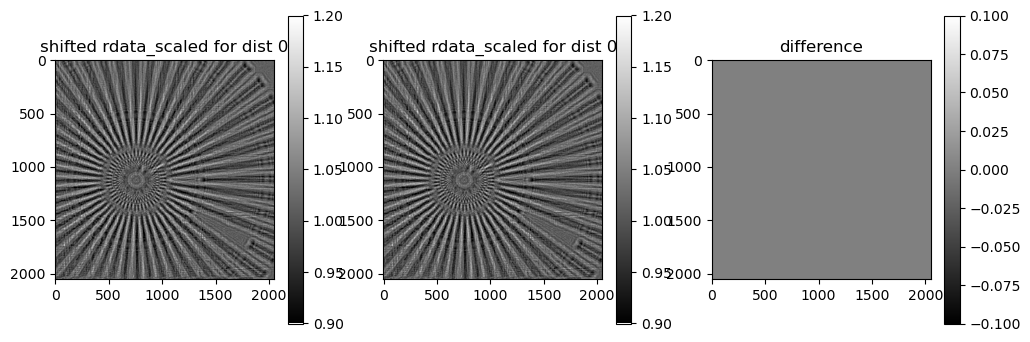

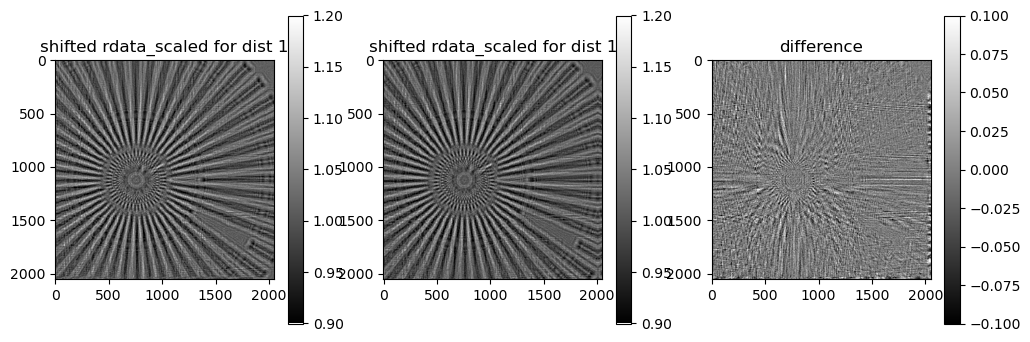

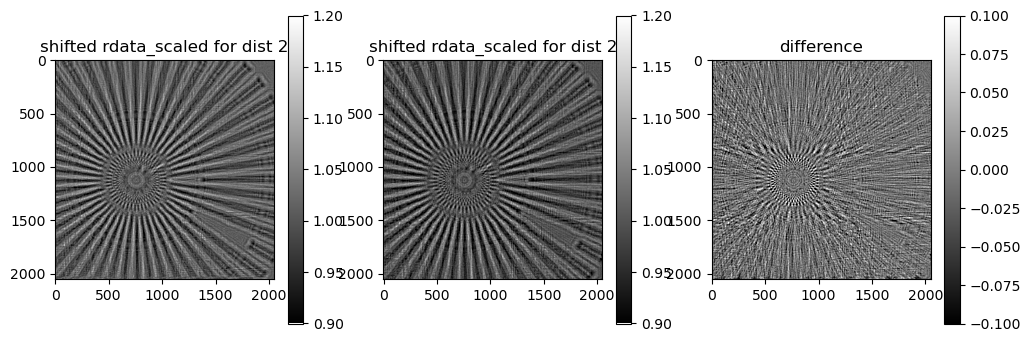

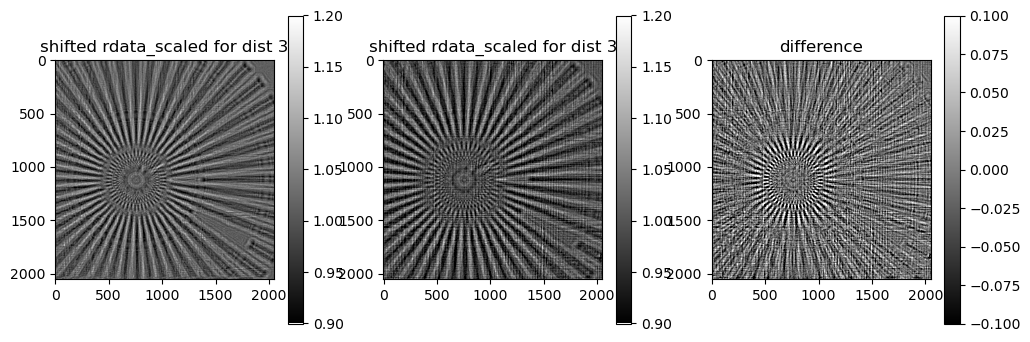

In [19]:
def apply_shift(psi, p):
    """Apply shift for all projections."""
    psi = cp.array(psi)
    p = cp.array(p)
    tmp = cp.pad(psi,((0,0),(n//2,n//2),(n//2,n//2)), 'symmetric')
    [x, y] = cp.meshgrid(cp.fft.rfftfreq(2*n),
                         cp.fft.fftfreq(2*n))
    shift = cp.exp(-2*cp.pi*1j *
                   (x*p[:, 1, None, None]+y*p[:, 0, None, None]))
    res0 = cp.fft.irfft2(shift*cp.fft.rfft2(tmp))
    res = res0[:, n//2:3*n//2, n//2:3*n//2].get()
    return res

rdata_scaled = rdata.copy()
for k in range(ndist):    
    a = apply_shift(rdata[k:k+1,0],-shifts[k:k+1,0])[0]# note first shift then magnification
    a = ndimage.zoom(a,1/norm_magnifications[k])
    rdata_scaled[k] = a[a.shape[0]//2-n//2:a.shape[0]//2+n//2,a.shape[1]//2-n//2:a.shape[1]//2+n//2]        
    
for k in range(ndist):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    im=axs[0].imshow(rdata_scaled[0,0],cmap='gray',vmin = 0.9,vmax=1.2 )
    axs[0].set_title(f'shifted rdata_scaled for dist {k}')
    fig.colorbar(im)
    im=axs[1].imshow(rdata_scaled[k,0],cmap='gray',vmin = 0.9,vmax=1.2 )
    axs[1].set_title(f'shifted rdata_scaled for dist {k}')
    fig.colorbar(im)        
    im=axs[2].imshow(rdata_scaled[k,0]-rdata_scaled[0,0],cmap='gray',vmin =-0.1,vmax=0.1 )
    axs[2].set_title(f'difference')
    fig.colorbar(im)        

In [20]:
def CTFPurePhase(rads, wlen, dists, fx, fy, alpha):
   """
   weak phase approximation from Cloetens et al. 2002




   Parameters
   ----------
   rad : 2D-array
       projection.
   wlen : float
       X-ray wavelentgth assumes monochromatic source.
   dist : float
       Object to detector distance (propagation distance) in mm.
   fx, fy : ndarray
       Fourier conjugate / spatial frequency coordinates of x and y.
   alpha : float
       regularization factor.
       
   Return
   ------
   phase retrieved projection in real space
   """    
   numerator = 0
   denominator = 0    
   for j in range(0, len(dists)):    
       rad_freq = np.fft.fft2(rads[j])
       taylorExp = np.sin(np.pi*wlen*dists[j]*(fx**2+fy**2)) 
       numerator = numerator + taylorExp * (rad_freq)
       denominator = denominator + 2*taylorExp**2 
   numerator = numerator / len(dists)
   denominator = (denominator / len(dists)) + alpha
   phase = np.real(  np.fft.ifft2(numerator / denominator) )
   phase = 0.5 * phase
   return phase


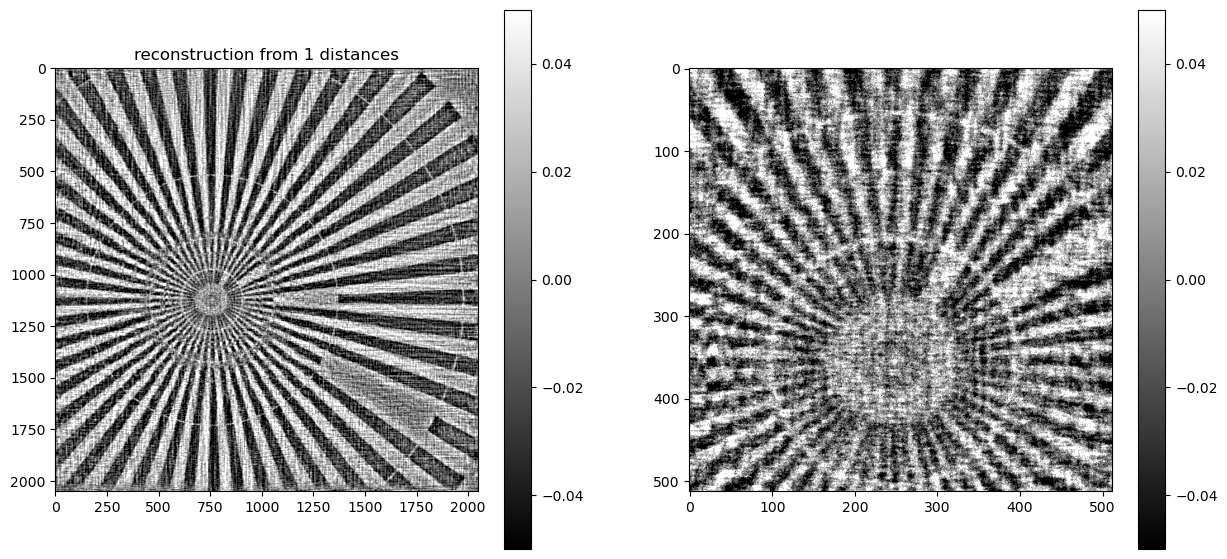

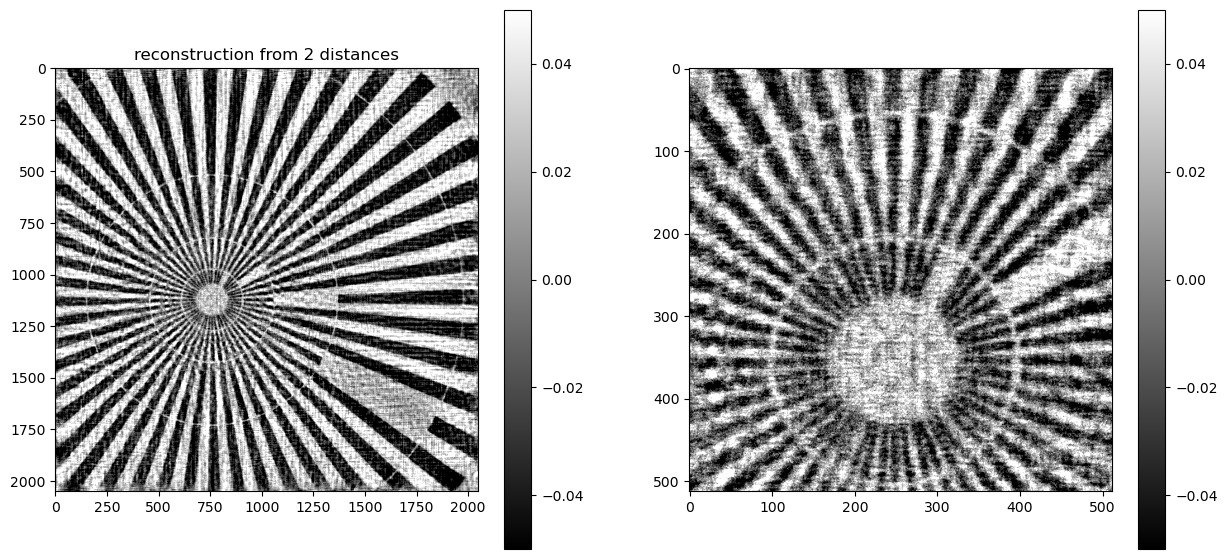

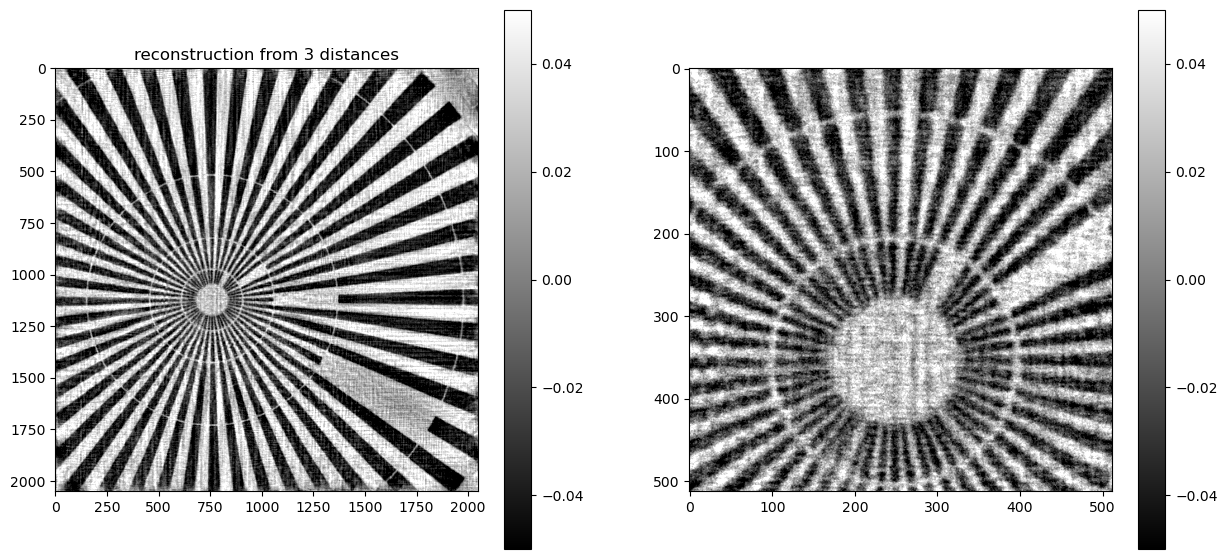

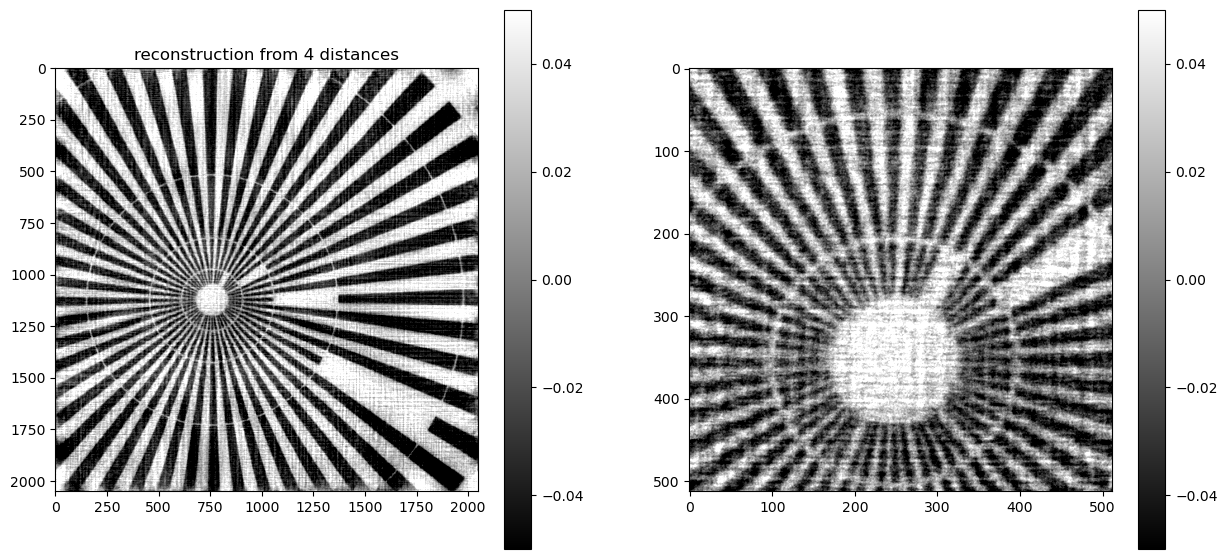

In [21]:

alpha = [1e-1,1e-2,1e-2,1e-3]

for k in range(1,5):
    ndist = k
    rads = rdata_scaled[:ndist,0]
    distances_rec = (distances/norm_magnifications**2)[:ndist]

    fx = np.fft.fftfreq(n,d=voxelsize)
    [fx,fy] = np.meshgrid(fx,fx)

    wlen = PLANCK_CONSTANT * SPEED_OF_LIGHT/energy
    delta_beta = 10
    
    recCTFPurePhase = CTFPurePhase(rads, wlen, distances_rec, fx, fy, alpha[k-1])
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    im=axs[0].imshow(recCTFPurePhase,cmap='gray',vmax=0.05,vmin=-0.05)
    axs[0].set_title(f'reconstruction from {k} distances')
    fig.colorbar(im)
    im=axs[1].imshow(recCTFPurePhase[n//2-256:n//2+256,n//2-256-256:n//2+256-256],cmap='gray',vmax=0.05,vmin=-0.05)
    fig.colorbar(im)
